In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [3]:
def vector1H(x, maxInd):
    out = np.zeros(maxInd)
    out[x-1] = 1
    return out

def mat1H(x, maxInd):
    out = np.zeros((x.shape[0], x.shape[1], maxInd))
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            out[i,j,:] = vector1H(x[i,j], maxInd)
    return out

def mat1H2(y, maxInd):
    out = np.zeros((y.shape[0], maxInd))
    for i in range(y.shape[0]):
        out[i,:] = vector1H(y[i], maxInd)
    return out

In [6]:
filename = 'data2.h5'

with h5py.File(filename, 'r') as f:
    # List all groups
    print("Keys: %s" % f.keys())
    # Get the data
    test_labels = f[list(f.keys())[0]][:]
    test_data = f[list(f.keys())[1]][:]
    train_labels = f[list(f.keys())[2]][:]
    train_data = f[list(f.keys())[3]][:]
    val_labels = f[list(f.keys())[4]][:]
    val_data = f[list(f.keys())[5]][:]
    wordDict = f[list(f.keys())[6]][:]


Keys: <KeysViewHDF5 ['testd', 'testx', 'traind', 'trainx', 'vald', 'valx', 'words']>


In [40]:
def initialize_weights(inputDim,numNeurons,activation,std,mean=0):
    if activation == "sigmoid" or activation == "softmax":
        w = np.random.normal(mean,std, inputDim*numNeurons).reshape(numNeurons, inputDim)
        b = np.random.normal(mean,std, numNeurons).reshape(numNeurons,1)
        weights = np.concatenate((w, b), axis=1)
    elif activation == 'we':
        weights = np.random.normal(mean, std, numNeurons*inputDim).reshape((numNeurons,inputDim))
    return weights

def select_activation(x,activation):
    if activation == "sigmoid":
        y = 1 / (1 + np.exp(-x))
        return y
    elif actiavation == "softmax":
        expx = np.exp(x - np.max(x))
        y = expx/np.sum(expx, axis=0)
        return y
    elif actiavation == "we":
        return x
    
def activation_backward(x):
    if activation == "sigmoid":
        return 2*(x*(1-x))
    elif actiavation == "softmax":
        return x*(1-x)
    elif actiavation == "we":
        return np.ones(x.shape)

def activate_layer(x,activation,weights):
    if activation == "sigmoid" or activation == "softmax":
        if(x.ndim == 1):
                x = x.reshape(x.shape[0],1)
        numSamples = x.shape[1]
        tempInp = np.r_[x, [np.ones(numSamples)*-1]]
        print(tempInp.shape)
        lastActiv = select_activation(np.matmul(weights, tempInp),activation)        
        
    elif activation == 'we':
        layerOut = np.zeros((x.shape[0],x.shape[1], 250))
        for m in range(layerOut.shape[0]):
            layerOut[m,:,:] = select_activation(np.matmul(x[m,:,:], weights),activation)
        layerOut = layerOut.reshape((layerOut.shape[0], layerOut.shape[1] * layerOut.shape[2]))
        lastActiv = layerOut.T
        return lastActiv

In [44]:
weightsE = initialize_weights(32,250,"softmax",0.01)
print(weightsE.shape)



(250, 33)


In [7]:
class Layer:
    def __init__(self, inputDim, numNeurons, activation, std, mean=0):
        self.inputDim = inputDim
        self.numNeurons = numNeurons
        self.activation = activation
        if self.activation == 'sigmoid' or self.activation == 'softmax':
            self.weights = np.random.normal(mean,std, inputDim*numNeurons).reshape(numNeurons, inputDim)
            self.biases = np.random.normal(mean,std, numNeurons).reshape(numNeurons,1)
            self.weightsE = np.concatenate((self.weights, self.biases), axis=1)
        elif self.activation == 'we':
            self.dictSize = numNeurons
            self.D = inputDim
            self.weights = np.random.normal(mean, std, dictSize*D).reshape((dictSize,D))
            
        
        self.delta = None
        self.error = None
        self.lastActiv = None
        
        self.prevUpdate = 0
        
        
    def actFcn(self,x):
        if(self.activation == 'sigmoid'):
            expx = np.exp(2*x)
            return expx/(1+expx)
        elif(self.activation == 'softmax'):
            expx = np.exp(x - np.max(x))
            return expx/np.sum(expx, axis=0)
        elif(self.activation == 'we'):
            return x
                    
    def activate(self, x):
        if self.activation == 'sigmoid' or self.activation == 'softmax':
            if(x.ndim == 1):
                x = x.reshape(x.shape[0],1)
            numSamples = x.shape[1]
            tempInp = np.r_[x, [np.ones(numSamples)*-1]]
            
            #print('hLayerW', self.weights.shape)
            #print('hLayerInp', tempInp.shape)
            
            self.lastActiv = self.actFcn(np.matmul(self.weightsE, tempInp))
        elif self.activation == 'we':
            #print('x: \n', x, x.shape)
            #print('w: \n', self.weights, self.weights.shape)
            layerOut = np.zeros((x.shape[0],x.shape[1], self.D))
            for m in range(layerOut.shape[0]):
                layerOut[m,:,:] = self.actFcn(np.matmul(x[m,:,:], self.weights))
            layerOut = layerOut.reshape((layerOut.shape[0], layerOut.shape[1] * layerOut.shape[2]))
            self.lastActiv = layerOut.T
            #print('weOut', layerOut.shape)
        return self.lastActiv
    
    def derActiv(self, x):
        if(self.activation == 'sigmoid'):
            return 2*(x*(1-x))
        elif(self.activation == 'softmax'):
            return x*(1-x)
        elif(self.activation == 'we'):
            return np.ones(x.shape)
    
    def __repr__(self):
        return "Input Dim: " + str(self.inputDim) + ", Number of Neurons: " + str(self.numNeurons) + "\n Activation: " + self.activation

In [8]:
class WordNet:
    def __init__(self):
        self.layers = []
        
    def addLayer(self, layer):
        self.layers.append(layer)
        
    def forward(self, inp):
        out = inp
        for lyr in self.layers:
            out = lyr.activate(out)
        return out
    
    def prediction(self, inp):
        out = self.forward(inp)
        if(out.ndim == 1):
            return np.argmax(out)
        return np.argmax(out, axis=0)
    
    def predictionTopK(self, inp, k):
        out = self.forward(inp)
        #print(out)
        return np.argpartition(out, -k, axis=0)[-k:]
        
    
    def backProp(self, inp, out, lrnRate, momCoeff, batchSize):
        net_out = self.forward(inp)
        #print('network out: ', net_out.shape)
        for i in reversed(range(len(self.layers))):
            lyr = self.layers[i]
            #outputLayer
            if(lyr == self.layers[-1]):
                lyr.delta = out - net_out
            #hiddenLayer
            else:
                nextLyr = self.layers[i+1]
                nextLyr.weights = nextLyr.weightsE[:,0:nextLyr.weights.shape[1]]
                lyr.error = np.matmul(nextLyr.weights.T, nextLyr.delta)
                derMatrix = lyr.derActiv(lyr.lastActiv)
                lyr.delta = derMatrix * lyr.error
        
        #update weights
        for i in range(len(self.layers)):
            lyr = self.layers[i]
            #write dynamic if later
            if(i == 0):
                if(inp.ndim == 1):
                    inp = inp.reshape(inp.shape[0],1)
                numSamples = inp.shape[1]
                inputToUse = inp
            else:
                numSamples = self.layers[i - 1].lastActiv.shape[1]
                inputToUse = np.r_[self.layers[i - 1].lastActiv, [np.ones(numSamples)*-1]]
            #print('delta of layer[' + str(i) + ']', lyr.delta.shape)
            #print('inputToUse.T of layer[' + str(i) + ']', inputToUse.T.shape)
            if(lyr.activation == 'sigmoid' or lyr.activation == 'softmax'):
                update =  (lrnRate * np.matmul(lyr.delta, inputToUse.T))/batchSize
                lyr.weightsE += update + momCoeff * lyr.prevUpdate
            elif(lyr.activation == 'we'):
                delta3d = lyr.delta.reshape((3,batchSize,lyr.D))
                inputToUse = np.transpose(inputToUse, (1,2,0))
                update = np.zeros((inputToUse.shape[1], delta3d.shape[2]))
                for i in range(delta3d.shape[0]):
                    update += lrnRate * np.matmul(inputToUse[i,:,:], delta3d[i,:,:])
                #mean the updates for each separate word
                #update = update/delta3d.shape[0]
                update = update/batchSize
                lyr.weights += update + momCoeff * lyr.prevUpdate
            lyr.prevUpdate = update
            
    def train(self, inp, out, inpTest, outTest, lrnRate, momCoeff, epochNum, batchSize):
        cveList = []
        
        for ep in range(epochNum):
            print('Epoch', ep)
            
            randomIndexes = np.random.permutation(len(inp))
            inp = inp[randomIndexes]
            out = out[randomIndexes]
            numBatches = int(np.floor(len(inp)/batchSize))
            
            for j in range(numBatches):
                batch_inp = inp[batchSize*j:batchSize*j+batchSize]
                batch_out = out[batchSize*j:batchSize*j+batchSize]
                
                batch_inp_1H = mat1H(batch_inp, dictSize)
                batch_out_1H = mat1H2(batch_out, dictSize).T
                
                self.backProp(batch_inp_1H, batch_out_1H, lrnRate, momCoeff, batchSize)
            
            valOutput = self.forward(inpTest)
            #print('Prediction Probs \n', valOutput)
            #print('Test \n', outTest)
            
            crossErr = - np.sum(np.log(valOutput) * outTest.T)/valOutput.shape[1]
            print('Cross-Entropy Error ', crossErr)
            cveList.append(crossErr)
            
            valAcc = np.sum(self.prediction(inpTest) == np.argmax(outTest.T, axis=0))
            print('Correct: ', valAcc)
            print('Accuracy: ', valAcc/valOutput.shape[1])
                
        return cveList
    
    def __repr__(self):
        retStr = ""
        for i, lyr in enumerate(self.layers):
            retStr += "Layer " + str(i) + ": " + lyr.__repr__() + "\n"
        return retStr

In [12]:
P = 256
D = 32
dictSize = 250

print(Layer(D, dictSize, 'we', 0.2))

Input Dim: 32, Number of Neurons: 250
 Activation: we


In [9]:
P = 256
D = 32
dictSize = 250

nn = WordNet()
nn.addLayer(Layer(D, dictSize, 'we', 0.2))
nn.addLayer(Layer(3*D, P, 'sigmoid', 0.2))
nn.addLayer(Layer(P, dictSize, 'softmax', 0.2))

learnRate = 0.35
momCoeff = 0.85
batchSize = 250
epoch = 50

val_inp_1H = mat1H(val_data, dictSize)
val_labels_1H = mat1H2(val_labels, dictSize)

errors = nn.train(train_data, train_labels, val_inp_1H, val_labels_1H,\
                  learnRate, momCoeff,\
                  epoch, batchSize)

Epoch 0
Cross-Entropy Error  3.4755334712386245
Correct:  12750
Accuracy:  0.27419354838709675
Epoch 1
Cross-Entropy Error  3.3098787618544874
Correct:  13570
Accuracy:  0.2918279569892473
Epoch 2
Cross-Entropy Error  3.214277212529971
Correct:  14053
Accuracy:  0.3022150537634409
Epoch 3
Cross-Entropy Error  3.1372798137116815
Correct:  14505
Accuracy:  0.31193548387096776
Epoch 4
Cross-Entropy Error  3.0832075305528854
Correct:  14782
Accuracy:  0.31789247311827956
Epoch 5


KeyboardInterrupt: 

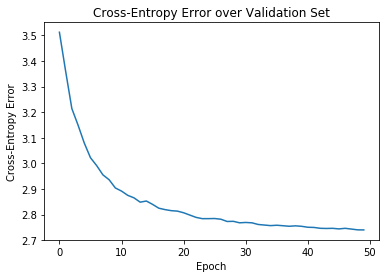

In [16]:
plt.plot(errors)
plt.title('Cross-Entropy Error over Validation Set')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Error')
plt.show()

In [26]:
num_samples = 5

random_sample_indexes = np.random.permutation(len(test_data))[0:num_samples]

test_samples = test_data[random_sample_indexes]
test_outputs = test_labels[random_sample_indexes]

test_samples_1H = mat1H(test_samples, dictSize)
test_labels_1H = mat1H2(test_outputs, dictSize)

top10predictions = nn.predictionTopK(test_samples_1H, 10)

print(top10predictions)

for i in range(num_samples):
    print('[' + str(i+1) + '] ' + str(wordDict[test_samples[i,0]-1].decode("utf-8"))  + ', ' + \
          str(wordDict[test_samples[i,1]-1].decode("utf-8")) \
          + ', ' + str(wordDict[test_samples[i,2]-1].decode("utf-8")))
    strin = 'The Top-K predictions are: {'
    for j in range(10):
        strin += (str(wordDict[top10predictions[j,i]].decode("utf-8"))) + ', '
    print(strin + '}')

[[241 201  43  73 109]
 [198 210 104 154 178]
 [ 58 213 139 191  41]
 [155  22  27  22 189]
 [106  73  58 166  31]
 [ 45 157  71  88  50]
 [ 22 230 198 157 182]
 [ 88 203 175 173 183]
 [143 143  95 143 199]
 [190  57 200 192  67]]
[1] long, time, ago
The Top-K predictions are: {i, at, right, ago, last, now, ,, ?, ., then, }
[2] do, nt, know
The Top-K predictions are: {any, when, how, ,, what, that, who, if, ., where, }
[3] see, who, 's
The Top-K predictions are: {not, on, there, going, right, out, at, up, here, in, }
[4] want, to, do
The Top-K predictions are: {what, more, is, ,, with, ?, that, this, ., it, }
[5] one, day, we
The Top-K predictions are: {could, will, know, have, do, did, can, were, want, are, }


In [45]:
def random_index(sample_size):
    random_index = []
    for i in range(sample_size):
        index = random.randint(0,46500)
        random_index.append(index)
    return random_index

def pick_sample(data,label,sample_size):
    sample = []
    labels = []
    sample_index = random_index(sample_size)
    for i in sample_index:
        sample.append(data[i])
        labels.append(label[i])
    return sample,labels

def predict(words,output):
    pred_rows = []
    for i in range(len(output)):
        word_index = output[i].argsort()[-10:][::-1]
        pred_words = []
        for word in word_index: 
            pred_words.append(str(words[word].decode("utf-8")))
        pred_rows.append((pred_words))
    return pred_rows

def print_preds(random_sample,pred_rows,words):
    for i in range(len(random_sample)):
        tri = "sample trigram: "
        for j in range(len(random_sample[i])):
            tri+=str(words[random_sample[i][j]].decode("utf-8"))+" "
        tri += " ----> label: " + str(words[test_label[i]].decode("utf-8"))
        print(tri)
        print("Top 10 predictions: ",pred_rows[i])

In [ ]:
random_sample,test_label = pick_sample(x_test,y_test,200)
random_sample_vector = input_vector(random_sample)
random_sample_vector = np.squeeze(random_sample_vector,axis=1)
random_sample = random_sample[:5]
test_label  = test_label[:5]

In [ ]:
_,_,output = forward(random_sample_vector, we)
output = output[:5]

In [ ]:
pred_rows = predict(words,output)
print_preds(random_sample,pred_rows,words)